# Coronavirus Reverse Engineering

## Protein Recognition and Classification

In a previous [notebook](./coronaversing.ipynb) we did an exploratory analysis of the data we collected from online sources and created a database of regions for each genome. The portions of the genome for each sample is classified into 3 types: ORF (a potential coding frame), UTR (untranslated regions at the 5' and 3' ends of the genome) and ING (intergenic region, located between 2 ORFs). Each portion has a label assigned, for example an UTR region could be "3UTR" or "5UTR" and ORFs could be "S", "N" or "ORF1ab", and so on, depending on which protein is codifying. The idea is to have a standardized mechanism to access regions of the genome common to all coronavirus samples to perform large scale analysis efficiently.

At this point, the labels for each region are left "undefined", since we need to execute a detailed analysis of each frame to recognize what is coding for. For example, given a coronavirus genome and the list of ORFs, how do we know which one is the ORF1a and how to join it with ORF1b to get ORF1ab? These are (usually) the first two ORFs that combined make up two thirds of the genome. Joining them it's tricker, since we have to locate the slippery sequence and perform a -1 frame shift. Sometimes there is an ORF in the 5'UTR region and the "untranslated region" now becomes potentially translatable. 

How do we know where the structural proteins coding segment are? Coronaviruses encode three conserved membrane-associated proteins that are incorporated in virions: spike (S), envelope (E), membrane (M) and a nucleoprotein (N). These four proteins seems to occur in the order S–E–M–N but between those genes, there are species-specific accessory proteins. How do we recognize these and find common sequences to classify them within a specie?

Some of the details that we have to figure out.

**TABLE OF CONTENTS**

* [Machine Learning ORF Tagging Algorithm](#section1)
   * [Exploring ORF1a](#section2)
   * [Training samples (CDS)](#section3)

In [292]:
from matplotlib import pyplot as plt

from IPython.display import display, HTML
from IPython.display import Markdown as md
from IPython.core.display import Image
import time
from sklearn.linear_model import LinearRegression

from reportlab.lib import colors
from reportlab.lib.units import cm

import matplotlib.pyplot as plt
import forgi.visual.mplotlib as fvm
import forgi

from Bio.Seq import Seq
from Bio import Entrez
from Bio.Graphics import GenomeDiagram
from Bio import SeqIO
from Bio.SeqFeature import SeqFeature, FeatureLocation
from Bio.Alphabet import IUPAC
from Bio.SeqUtils import seq3
from Bio import Align
from Bio.SeqRecord import SeqRecord

import bisect 
import pandas as pd
import seaborn as sb
import numpy as np
import seaborn as sns
from scipy import stats
import math
import zlib

from intervaltree import Interval, IntervalTree
from sklearn.feature_extraction.text import TfidfVectorizer
from stop_words import get_stop_words

import datetime
import os
import lzma as xz

# file periodically removed to update with the latest data
cache_vrs_file = ".cache_vrs.pkl" 
cache_cds_file = ".cache_cds.pkl" 
cache_regions_file = ".cache_regions.pkl" 

hidden_columns = ["sequence", "file_path"]
hidden_cds_columns = ["translation", "file_path", "location"]
hidden_regions_columns = ["id", "rna", "protein", "path"]

SLIPPERY_SEQUENCE = "UUUAAAC"

if os.path.isfile(cache_regions_file):
    corona_db = pd.read_pickle(cache_regions_file)
else:
    %run ./coronaversing.ipynb
    
if os.path.isfile(cache_vrs_file):
    corona = pd.read_pickle(cache_vrs_file)
    corona_cds = pd.read_pickle(cache_cds_file)
    
    # set index
    corona = corona.set_index("id")
    corona_cds = corona_cds.set_index("protein_id")
    
    # at this point we would like to analyze pretty much complete genomes
    corona_incomplete = corona[(corona["unknown"] > 0.001) | (corona["length"] < 27000)]

    # drop duplicates
    corona = corona[~corona.index.duplicated(keep='first')]
    corona_cds = corona_cds[~corona_cds.index.duplicated(keep='first')]
else:
    %run ./coronaversing.ipynb
    
corona_db = corona_db[~corona_db["id"].isin(corona_incomplete.index)]
corona_cds = corona_cds[~corona_cds["oid"].isin(corona_incomplete.index)]

# 1. Machine Learning ORF Tagging Algorithm <a id="section1"></a>

Before introducing machine learning concepts for protein classification, let's take a look at the data we have. This is how the current DB looks like for a given genome (we'll use NC_045512.2 as a reference). 

In [6]:
ncov = corona_db[corona_db["id"] == "NC_045512.2"]
display(HTML(ncov.drop(hidden_regions_columns, axis=1).to_html()))

,type,label,date,collection,start,end,length,unknown
rid,,,,,,,,
NC_045512.2|UTR@00000,UTR,5UTR,2020-03-13,Dec-2019,0,265,265,0.0
NC_045512.2|ORF@00265,ORF,UNDEF,2020-03-13,Dec-2019,265,13483,13218,0.0
NC_045512.2|ING@13483,ING,UNDEF,2020-03-13,Dec-2019,13483,13767,284,0.0
NC_045512.2|ORF@13767,ORF,UNDEF,2020-03-13,Dec-2019,13767,21555,7788,0.0
NC_045512.2|ORF@21535,ORF,UNDEF,2020-03-13,Dec-2019,21535,25384,3849,0.0
NC_045512.2|ORF@25331,ORF,UNDEF,2020-03-13,Dec-2019,25331,25448,117,0.0
NC_045512.2|ORF@25392,ORF,UNDEF,2020-03-13,Dec-2019,25392,26220,828,0.0
NC_045512.2|ORF@26182,ORF,UNDEF,2020-03-13,Dec-2019,26182,26281,99,0.0
NC_045512.2|ORF@26244,ORF,UNDEF,2020-03-13,Dec-2019,26244,26472,228,0.0


As you might guess, ORF@00265 and ORF@13767 are ORF1a (\~13.2kbp) and ORF1b (\~7.7kpb). Ideally, we would like to remove ORF1b from our database and replace it with ORF1ab, since that is consistent to what happens in reality : the first gene is translated as ORFs 1a and 1ab, with 1ab resulting from a pseudoknot-induced -1 ribosomal frame shifting event at a slippery sequence of UUUAAAC at the ORF1a/ORF1b junction, which we will have to find to get the correct aminoacid sequence of the 1ab polyprotein which it's around ~21kbp.

The first open reading frame ORF@21535 downstream ORF1ab encodes the spike (S) glycoprotein and the size it's around ~3.8 kbps. E, M and N are encoded by ORF@26244, ORF@26522 and ORF@28273 respectively. We know this because the genbank [entry](https://www.ncbi.nlm.nih.gov/nuccore/NC_045512.2) at NCBI contains annotations with the name of each CDS. This annotations aren't always available, so we should develop a method to generically tag each coding region with the protein it codifies.

Besides the polyprotein and the structural proteins there are a few other coding segments which we are going to deal later.

## 1.1 Exploring ORF1a <a id="section2"></a>

By looking at ORF1 on the sample above, seems natural to apply the following algorithm over our entire database.

* Find the 2 biggest ORFs on the genome. The bigger one is ORF1a and the other is ORF1b.
* Whatever it's on the left of ORF1a it's 5UTR (regardless if there are any additional ORFs on that region).
* We have to find the slippery sequence near the end of ORF1a and perform the frame shift to get the aminoacid sequence of ORF1ab. 

Before going there, let's plot the distribution of the biggest ORF for each genome to spot for anomalies.

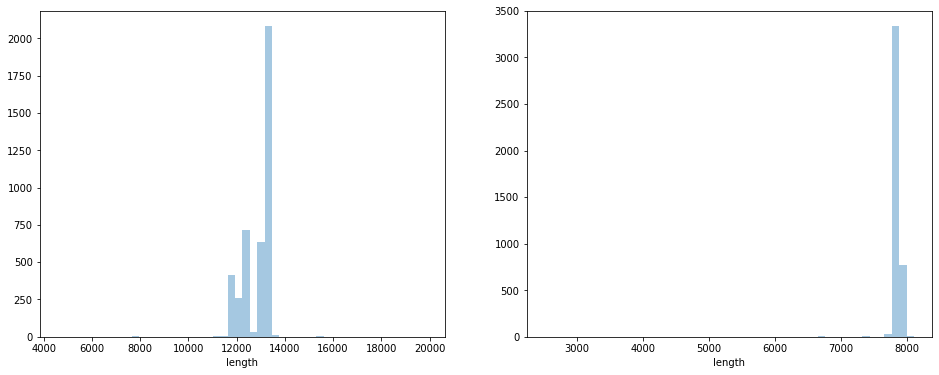

In [7]:
putative_orf1a = corona_db.groupby("id")["length"].max()
putative_orf1b = corona_db.groupby("id")["length"].apply(lambda x: x.nlargest(2).min())

fig, axs = plt.subplots(ncols=2, figsize=(16, 6));
sns.distplot(putative_orf1a, kde=False, ax=axs[0]);
sns.distplot(putative_orf1b, kde=False, ax=axs[1]);

# do some stats
mean_orf1a = putative_orf1a.mean()
std_orf1a = putative_orf1a.std()
mean_orf1b = putative_orf1b.mean()
std_orf1b = putative_orf1b.std()

In [8]:
print("[+] ORF1a mean size = %.2f bp" % mean_orf1a)
print("[+] ORF1b mean size = %.2f bp" % mean_orf1b)
print("[+] ORF1a std = %.2f bp" % std_orf1a)
print("[+] ORF1b std = %.2f bp" % std_orf1b)

[+] ORF1a mean size = 12825.50 bp
[+] ORF1b mean size = 7833.86 bp
[+] ORF1a std = 628.30 bp
[+] ORF1b std = 189.33 bp


The average size of both ORFs are consistent with the information available about the virus. But it's clear from the histogram that there are quite a few outliers. Let's set the lower limit for the gene size to 3 standard deviations.

In [9]:
lower_limit_orf1a = mean_orf1a - 3 * std_orf1a
lower_limit_orf1b = mean_orf1b - 3 * std_orf1b

outliers_orf1a = putative_orf1a[putative_orf1a < lower_limit_orf1a]
outliers_orf1b = putative_orf1b[putative_orf1b < lower_limit_orf1b]

print("[+] Total of outliers (orf1a) :", len(outliers_orf1a))
print("[+] Total of outliers (orf1b) :", len(outliers_orf1b))

[+] Total of outliers (orf1a) : 22
[+] Total of outliers (orf1b) : 26


So what's going on with this samples? Let's see how many belongs to both groups of outliers. Those are definitely fishy samples.

In [10]:
fishy_samples = list(set(outliers_orf1b.index).intersection(outliers_orf1a.index))
display(HTML(corona.loc[fishy_samples].drop(hidden_columns, axis=1).to_html()))

,length,date,information,description,unknown,country,host,strain,collection_date
id,,,,,,,,,
AY313906.1,29754,2005-02-28,1.187648,"SARS coronavirus GD69, complete genome",0.0,china,unknown,unknown,unknown
AY613948.1,29730,2005-02-28,1.189343,"SARS coronavirus PC4-13, complete genome",0.0,china,palm civet,unknown,unknown
MN486588.1,27933,2020-02-10,1.261989,"Porcine epidemic diarrhea virus strain Ah2016f2, complete genome",0.0,china,porcine,Ah2016f2,Feb-2016
FN430415.1,27593,2013-07-03,1.285347,"Infectious bronchitis virus NGA/A116E7/2006, complete genome",0.0,nigeria,unknown,unknown,2006
MH687975.1,27254,2018-11-12,1.293996,"Betacoronavirus sp. strain VZ_BetaCoV_22054_56, partial genome",0.0,viet nam,rattus argentiventer,VZ_BetaCoV_22054_56,09-Dec-2013
EU526388.1,27715,2009-01-14,1.274210,"Infectious bronchitis virus strain A2, complete genome",0.0,china,chicken,A2,unknown
AY351680.1,29749,2003-08-03,1.183152,"SARS coronavirus ZMY 1, complete genome",0.0,unknown,unknown,unknown,unknown
AY297028.1,29715,2003-05-19,1.188213,"SARS coronavirus ZJ01, complete genome",0.0,unknown,unknown,unknown,unknown
AY613947.1,29730,2005-02-28,1.187648,"SARS coronavirus GZ0402, complete genome",0.0,china,unknown,unknown,unknown


A lot of samples are  old and seems like they might be quite different from the reference genome of SARA-CoV-2 we are looking. I think it's safe to remove this samples from our database. We should get the starting point for each ORF1a sequence and whatever is on the left we should define it as a 5UTR region. What is the distribution of the value for the starting codon of ORF1a? 

[+] ORF1a start mean = 294.78 bp
[+] ORF1a start std = 516.21 bp


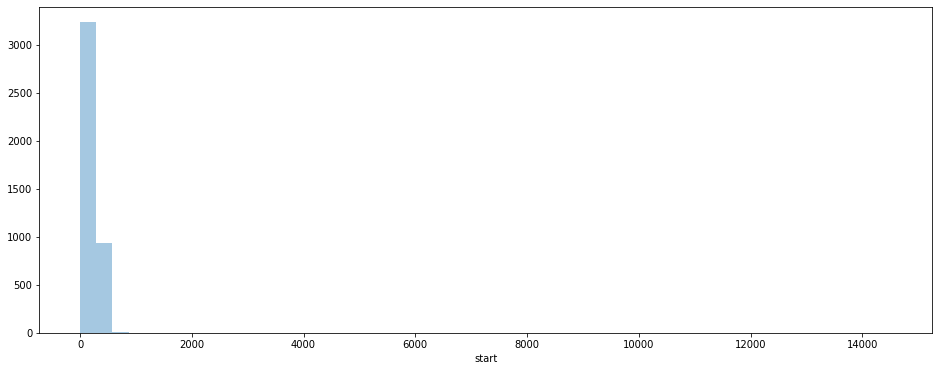

In [11]:
plt.figure(figsize=(16, 6))
orf1a = corona_db.sort_values("length", ascending=False).drop_duplicates(["id"],keep="first")

# get start codons
orf1a_start = orf1a["start"]
sns.distplot(orf1a_start, kde=False);

# do some stats
mean_start_orf1a = orf1a_start.mean()
std_start_orf1a = orf1a_start.std()

print("[+] ORF1a start mean = %.2f bp" % mean_start_orf1a)
print("[+] ORF1a start std = %.2f bp" % std_start_orf1a)

Again, there are a few outliers with starting codons way further from the average one which is \~280bp downstream the 5' end of the genome. We should define a cutoff (3 sigma) for this value and inspect the outliers .

In [12]:
start_orf1a = mean_start_orf1a + 3 * std_start_orf1a
outliers_orf1a = orf1a[orf1a["start"] > start_orf1a]

display(HTML(outliers_orf1a.drop(hidden_regions_columns, axis=1).to_html()))
print("[+] Total ORF1a outliers (based on the starting codon) :", len(outliers_orf1a))

,type,label,date,collection,start,end,length,unknown
rid,,,,,,,,
AY559088.1|ORF@02613,ORF,UNDEF,2004-09-24,unknown,2613,13398,10785,0.000000
AY595412.1|ORF@02921,ORF,UNDEF,2006-12-07,unknown,2921,13391,10470,0.000000
GU937797.1|ORF@02385,ORF,UNDEF,2011-03-27,unknown,2385,12639,10254,0.000000
AY394850.2|ORF@03360,ORF,UNDEF,2005-05-10,unknown,3360,13413,10053,0.000000
EPI_ISL_417198|ORF@04553,ORF,UNDEF,2020-03-12,2020,4553,13430,8877,0.000338
MN486588.1|ORF@04008,ORF,UNDEF,2020-02-10,Feb-2016,4008,12618,8610,0.000000
FN430415.1|ORF@12427,ORF,UNDEF,2013-07-03,2006,12427,20386,7959,0.000000
AY613948.1|ORF@13548,ORF,UNDEF,2005-02-28,unknown,13548,21435,7887,0.000000
AY613949.1|ORF@13548,ORF,UNDEF,2005-02-28,unknown,13548,21435,7887,0.000000


[+] Total ORF1a outliers (based on the starting codon) : 13


Is even 3 sigma a good measure of what an anomaly is suppose to be on this context? Looking at the cases on the table it just seems that this viruses contains an ORF1a gene much further from the 5' that others normally do. Is the ORF size and start position enough variables to predict which specific ORF is? My guess is that the aminoacid composition of the translated segment should play an important role as well.

When this type of problems arise, i.e. multiple variables are needed in order to spot anomalies and classify certain data, that's where machine learning comes handy. I don't think we need anything fancy here, something like a simple [random forest](https://en.wikipedia.org/wiki/Random_forest) would work. I also like RF because you can get a better grasp of what's going just by looking at the importances for each feature.

So let's give it a try. Before we have to craft our training dataset and we can use the CDS annotations for that.

## 1.1 Training samples (CDS) <a id="section3"></a>

We already have samples with the ORF1A and ORF1B gene tagged as CDS annotations and we can use those to build the training set for our algorithm. Let's see how many samples we have for each case.

In [303]:
# get everything with a reference to 1a
orf1a_cds = corona_cds[(corona_cds["type"] == "CDS") & ((corona_cds["gene"].str.contains("1A")) | 
                                                        (corona_cds["product"].str.contains("1a")))]

# remove orf1ab rows
orf1a_cds = orf1a_cds.drop(orf1a_cds[orf1a_cds["product"].str.contains("orf1ab")].index | 
                           orf1a_cds[orf1a_cds["product"].str.contains("1ab")].index | 
                           orf1a_cds[orf1a_cds["product"].str.contains("orf1a/1b")].index | 
                           orf1a_cds[orf1a_cds["gene"] == "ORF1A/B"].index | 
                           orf1a_cds[orf1a_cds["gene"] == "ORF1A/1B"].index | 
                           orf1a_cds[orf1a_cds["gene"] == "ORF 1A/1B"].index | 
                           orf1a_cds[orf1a_cds["gene"] == "ORF1AB"].index | 
                           orf1a_cds[orf1a_cds["gene"] == "PP1AB"].index | 
                           orf1a_cds[orf1a_cds["gene"] == "1AB"].index | 
                           orf1a_cds[orf1a_cds["product"].str.contains("orf1a/b")].index)

# get everything with a reference to 1b
orf1b_cds = corona_cds[(corona_cds["type"] == "CDS") & ((corona_cds["gene"].str.contains("1B")) | 
                                                        (corona_cds["product"].str.contains("1b")))]

# remove orf1ab rows
orf1b_cds = orf1b_cds.drop(orf1b_cds[orf1b_cds["product"].str.contains("orf1ab")].index | 
                           orf1b_cds[orf1b_cds["product"].str.contains("1ab")].index | 
                           orf1b_cds[orf1b_cds["product"].str.contains("orf1a/1b")].index | 
                           orf1b_cds[orf1b_cds["gene"] == "ORF1A/B"].index | 
                           orf1b_cds[orf1b_cds["gene"] == "ORF1A/1B"].index | 
                           orf1b_cds[orf1b_cds["gene"] == "ORF 1A/1B"].index | 
                           orf1b_cds[orf1b_cds["gene"] == "ORF1AB"].index | 
                           orf1b_cds[orf1b_cds["gene"] == "PP1AB"].index | 
                           orf1b_cds[orf1b_cds["gene"] == "1AB"].index | 
                           orf1b_cds[orf1b_cds["product"].str.contains("orf1a/b")].index)

print("[+] ORF1A tagged cases :", len(orf1a_cds))
print("[+] ORF1B tagged cases :", len(orf1b_cds))

[+] ORF1A tagged cases : 1013
[+] ORF1B tagged cases : 183


Of more than 5k samples we only have around 1k of genomes with ORF1A tagged and 10 times less with ORF1B tagged. It's a quite an unbalanced dataset, the good thing about RF is that we can easily deal with that by weighting each sample.

Let's plot the distribution of the start and end position of both of this ORFs to make sure we are not including some weird anomaly.

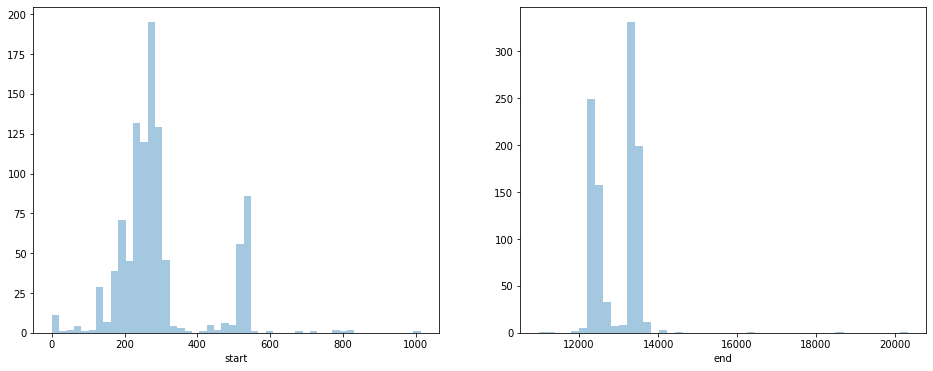

In [304]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 6));
sns.distplot(orf1a_cds["start"], kde=False, ax=axs[0]);
sns.distplot(orf1a_cds["end"], kde=False, ax=axs[1]);

In [305]:
orf1a_outliers = orf1a_cds[orf1a_cds["end"] > 15000]
display(HTML(orf1a_outliers.drop(hidden_cds_columns, axis=1).to_html()))

,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
ACV87243.1,polyprotein 1a,unknown,1,GQ427173.1,CDS,25-FEB-2010,531,20321,19791,0.0
AUS29610.1,pp1a replicase polyprotein,ORF1A,1,MG752895.1,CDS,27-JAN-2018,1014,18612,17598,0.0
AXP11706.1,polyprotein 1a,ORF1A,1,MF685025.1,CDS,26-AUG-2018,820,16288,15468,0.0


There is definitely a typo on sample [GQ427173.1](https://www.ncbi.nlm.nih.gov/nuccore/MG752895.1). The CDS annotation that is suppose to be the polyprotein 1ab it's tagged as 1a and viceversa. The rest looks OK after manual inspection of the genbank entries. We can safely set a cutoff of 19k for the size of the ORF1A gene. 

In [306]:
orf1a_outliers = orf1a_cds[orf1a_cds["length"] > 19000]
orf1a_cds = orf1a_cds[~orf1a_cds.index.isin(orf1a_outliers.index)]
print("[+] ORF1A final samples :", len(orf1a_cds))

[+] ORF1A final samples : 1012


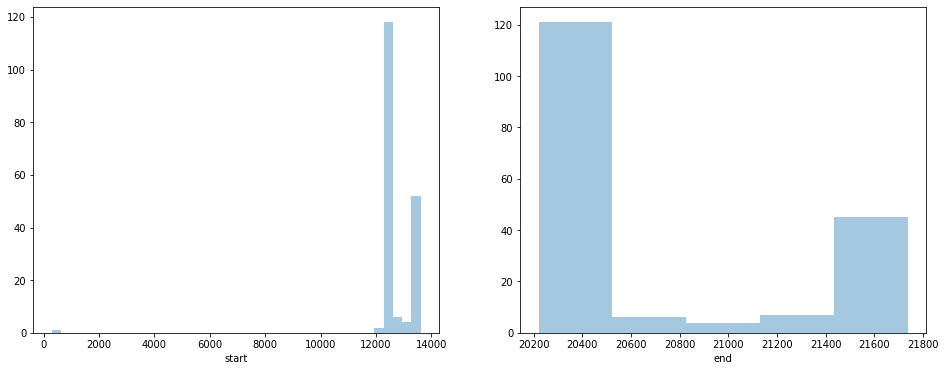

In [307]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 6));
sns.distplot(orf1b_cds["start"], kde=False, ax=axs[0]);
sns.distplot(orf1b_cds["end"], kde=False, ax=axs[1]);

Let's look at the outliers for ORF1B.

In [204]:
orf1b_outliers = orf1b_cds[orf1b_cds["start"] < 10000]
display(HTML(orf1b_outliers.drop(hidden_cds_columns, axis=1).to_html()))

,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
AQT33893.1,polyprotein,ORF1B,1,KX550281.1,CDS,04-MAR-2017,292,20637,20388,0.0


The KX550281.1 case definitely looks like a typo; by inspecting the [genbak entry](https://www.ncbi.nlm.nih.gov/nuccore/KX550281.1) this it's actually an ORF1AB gene, not ORF1B. We should remove this samples from our training dataset.

In [205]:
orf1b_cds = orf1b_cds[~orf1b_cds.index.isin(orf1b_outliers.index)]
print("[+] ORF1B final samples :", len(orf1b_cds))

[+] ORF1B final samples : 182


Finally, let's plot the length distribution of both ORFs to have an idea of the average size of each one.

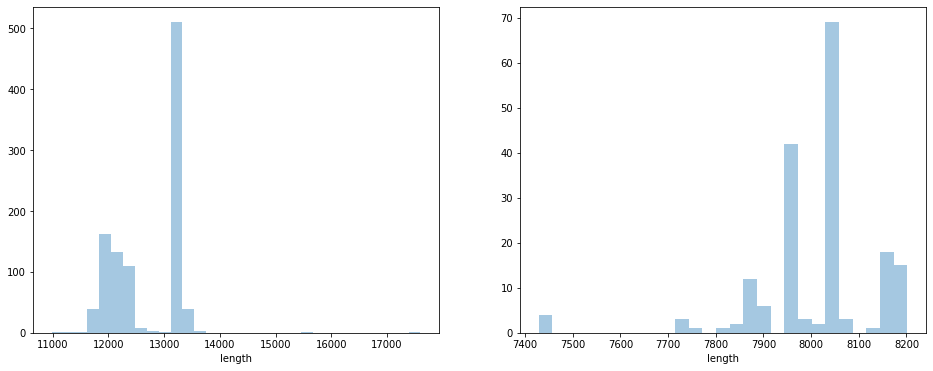

In [206]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 6));
sns.distplot(orf1a_cds["length"], kde=False, ax=axs[0]);
sns.distplot(orf1b_cds["length"], kde=False, ax=axs[1]);

Pretty good, so now we can safely set a cutoff for the size range of each type of ORF to avoid pollution of our dataset (since they don't overlap and are the biggest genes on the genome) 

In [215]:
# range for ORF1A gene
min_orf1a_size = orf1a_cds["length"].min()
max_orf1a_size = orf1a_cds["length"].max()

# range for ORF1B gene
min_orf1b_size = orf1b_cds["length"].min()
max_orf1b_size = orf1b_cds["length"].max()

print("[+] ORF1A (min, max) :", min_orf1a_size, "-", max_orf1a_size)

print("[+] ORF1B (min, max) :", min_orf1b_size, "-", max_orf1b_size)

orf1a_cds = corona_cds[(corona_cds["length"] >= min_orf1a_size) & (corona_cds["length"] <= max_orf1a_size)]
orf1b_cds = corona_cds[(corona_cds["length"] >= min_orf1b_size) & (corona_cds["length"] <= max_orf1b_size)]

print("[+] ORF1A final samples :", len(orf1a_cds))
print("[+] ORF1B final samples :", len(orf1b_cds))

[+] ORF1A (min, max) : 10978 - 17598
[+] ORF1B (min, max) : 7428 - 8202
[+] ORF1A final samples : 1445
[+] ORF1B final samples : 200


So now we have our ORF1 CDS that we are going to use as part of the training set. Let's get the remaining CDS.

In [216]:
not_orf1_cds = corona_cds[(~corona_cds.index.isin(orf1b_cds.index)) & 
                          (~corona_cds.index.isin(orf1a_cds.index))]

Ideally we would like to clean up this data set from ORF1AB frames, since those are not going to be classified. Let's plot the length distribution of the remaining ORF to find a cutoff size for those cases.

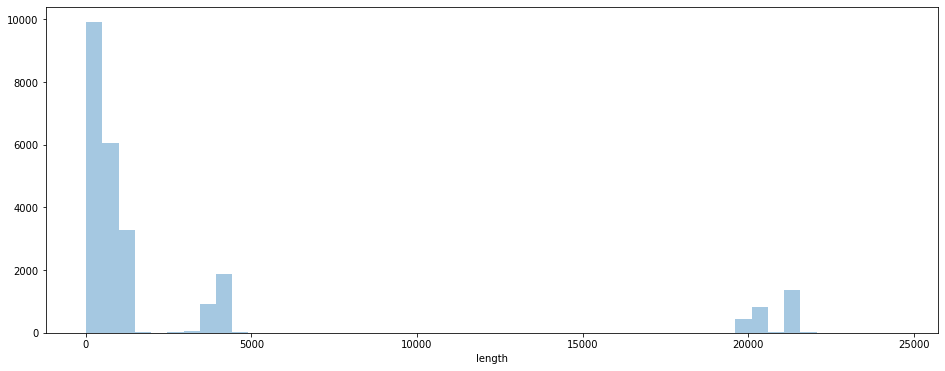

In [217]:
plt.figure(figsize=(16, 6))
sns.distplot(not_orf1_cds["length"], kde=False);

So yes, there is a pretty clear separation between ORF1ABs from the others.

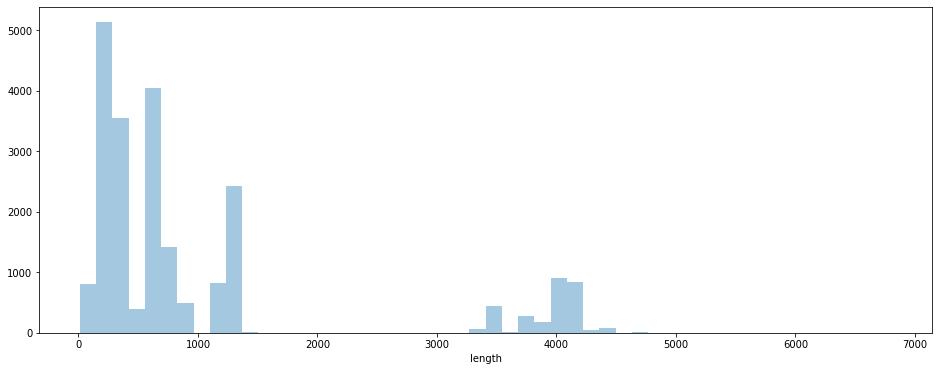

In [234]:
not_orf1_cds = not_orf1_cds[(not_orf1_cds["type"] == "CDS") & (not_orf1_cds["length"] < 15000)]
plt.figure(figsize=(16, 6))
sns.distplot(not_orf1_cds["length"], kde=False);

In [239]:
not_orf1_outliers = not_orf1_cds[not_orf1_cds["length"] > 5000]
display(HTML(not_orf1_outliers.drop(hidden_cds_columns, axis=1).to_html()))

,product,gene,codon_start,oid,type,date,start,end,length,unknown
protein_id,,,,,,,,,,
AYR18658.1,replicase polyprotein,unknown,1,MH687975.1,CDS,12-NOV-2018,11663,18467,6804,0.0


That case really looks like an ORF1B frame, so we should better move it to the other dataframe and remove it from here.

In [325]:
orf1b_cds = pd.concat([orf1b_cds, not_orf1_outliers])
not_orf1_cds = not_orf1_cds[(~not_orf1_cds.index.isin(not_orf1_outliers.index))]
print("[+] ORF remaining samples :", len(not_orf1_cds))

[+] ORF remaining samples : 21998


Now it's time to extract the structural proteins's CDS, which are S, E, M and N. After inspection, most of the time this CDS have a single letter gene name for each case.

In [326]:
corona_cds_orfs = {}

# some strings to filter out potential structures proteins from CDS
product_strings = {"S" : ["spike", "s protein"], 
                   "E" : ["envelope", " e protein"], 
                   "M" : ["m protein", "membrane m", "membrane protein"],
                   "N" : ["nucleocapsid", "nucloecapsid"]}

structural_proteins_ids = []
for sp in ["S", "E", "M", "N"]:
    corona_cds_orfs[sp] = not_orf1_cds[(not_orf1_cds["gene"] == sp) |
                                      (not_orf1_cds["product"] == sp.lower())]
    structural_proteins_ids += list(corona_cds_orfs[sp].index)

# let's account for the rest as accessory proteins
accessory_cds = not_orf1_cds[(~not_orf1_cds.index.isin(structural_proteins_ids))]

I'm sure the string search query we did on the product description of the CDS above polluted our dataset in both ways; we probably missed a few structural proteins from the CDS database and we got some incorrect ones. Let's plot the start, end and size distribution for each structural protein to spot for anomalies.